## Prepare Notebook

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['figure.dpi'] = 100

## Read Data

In [8]:
raw_sales_df = pd.read_csv("../../../data/btsa-causalarima_2021-11-02_2033/dataset.csv")

raw_sales_df.head()

,index,Dates,Sales,TruePrice,Price,hol,dec.sun,sat,sun,mon,tue,wed,thr
0,1,2017-09-01,1250.0,1.39,1.39,0,0,0,0,0,0,0,0
1,2,2017-09-02,1752.0,1.38,1.38,0,0,1,0,0,0,0,0
2,3,2017-09-03,417.0,1.38,1.38,0,0,0,1,0,0,0,0
3,4,2017-09-04,1346.0,1.38,1.38,0,0,0,0,1,0,0,0
4,5,2017-09-05,1144.0,1.37,1.37,0,0,0,0,0,1,0,0


## Format Data

In [9]:
sales_df = raw_sales_df.copy()

sales_df.columns = sales_df.columns.str.lower()

sales_df = sales_df \
    .drop("index", axis=1) \
    .assign(
        price_change = lambda x: x["trueprice"] != x["price"], 
        days_since_price_change = lambda x: x["price_change"].cumsum(),
        dates = lambda x: pd.to_datetime(x["dates"])
    ) \
    .sort_values("dates") \
    .fillna(method="ffill")

## EDA

In [10]:
price_change_date = sales_df.query("price_change").iloc[0]["dates"]

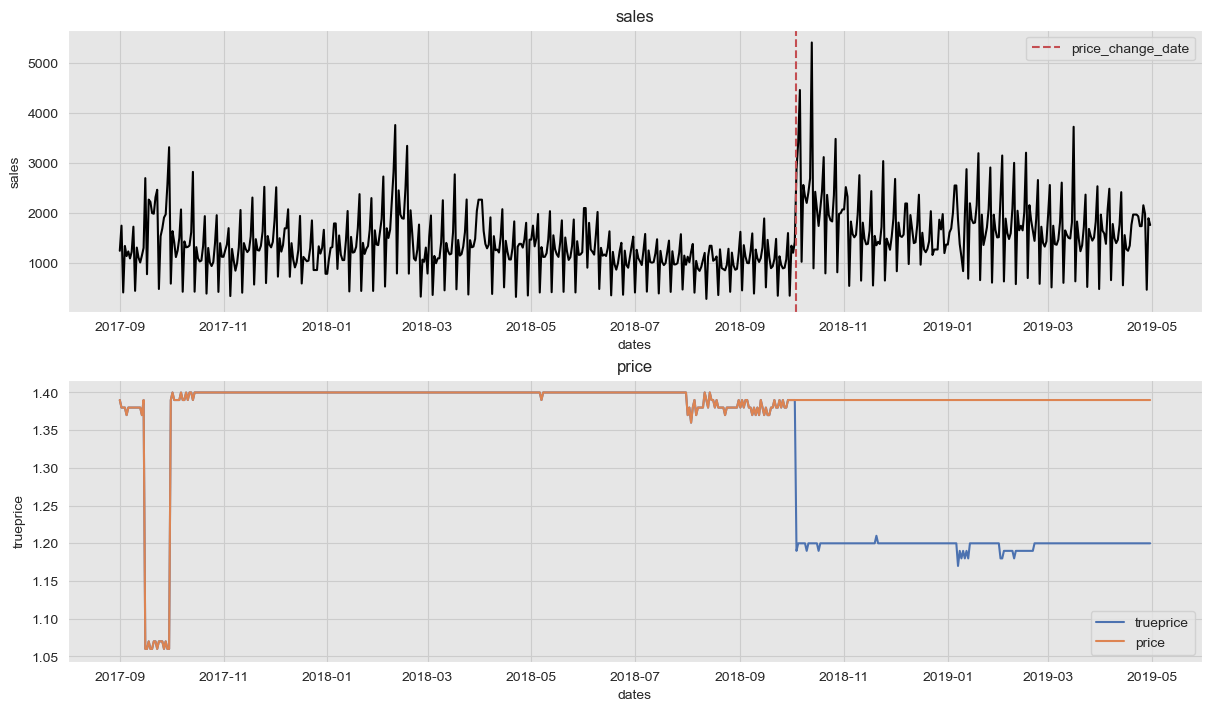

In [11]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(12, 7),
    constrained_layout=True
)

sns.lineplot(x="dates", y="sales", data=sales_df, color="black", ax=ax[0])
ax[0].axvline(x=price_change_date, color="C3", linestyle="--", label="price_change_date")
ax[0].legend()
ax[0].set(title="sales")
sns.lineplot(x="dates", y="trueprice", data=sales_df, color="C0", label="trueprice", ax=ax[1])
sns.lineplot(x="dates", y="price", data=sales_df, color="C1", label="price", ax=ax[1])
ax[1].set(title="price");

## Causal Impact

In [13]:
# https://github.com/WillianFuks/tfcausalimpact

from causalimpact import CausalImpact
from datetime import timedelta

data_df = sales_df \
    .set_index("dates") \
    .assign(sales = lambda x: np.log(x["sales"])) \
    [["sales", "hol", "dec.sun", "sat", "sun", "mon", "tue", "wed", "thr"]]

pre_period=[sales_df.iloc[0]["dates"], price_change_date]

post_period = [price_change_date + timedelta(days=1), sales_df.iloc[-1]["dates"]]

ci = CausalImpact(
    data=data_df,
    pre_period=pre_period,
    post_period=post_period
)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


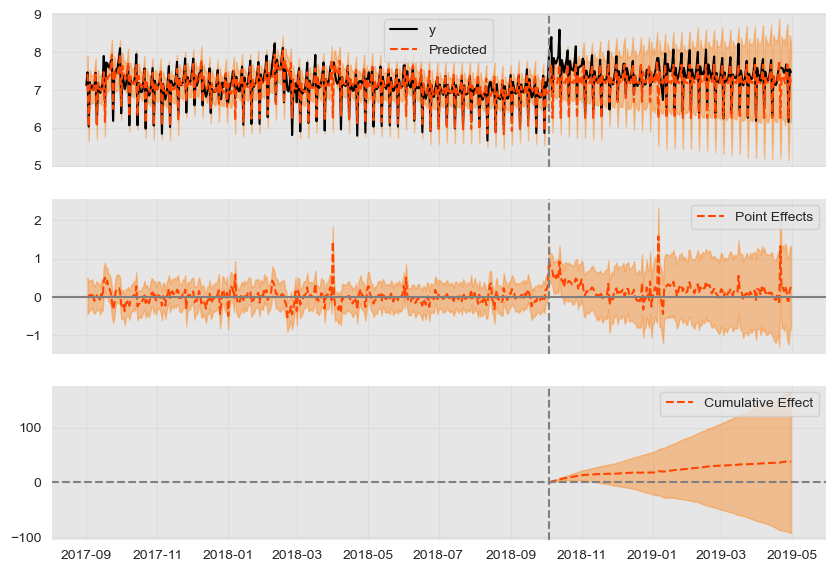

In [14]:
ci.plot()

In [17]:
print(ci.summary())

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    7.39               1536.52
Prediction (s.d.)         7.2 (0.32)         1498.22 (66.66)
95% CI                    [6.58, 7.84]       [1369.62, 1630.93]

Absolute effect (s.d.)    0.18 (0.32)        38.3 (66.66)
95% CI                    [-0.45, 0.8]       [-94.41, 166.9]

Relative effect (s.d.)    2.56% (4.45%)      2.56% (4.45%)
95% CI                    [-6.3%, 11.14%]    [-6.3%, 11.14%]

Posterior tail-area probability p: 0.27
Posterior prob. of a causal effect: 73.23%

For more details run the command: print(impact.summary('report'))


In [31]:
ci.model.components_by_name

OrderedDict([('LocalLevel/',
              <tensorflow_probability.python.sts.components.local_level.LocalLevel at 0x7fbb9c8e75b0>),
             ('SparseLinearRegression/',
              <tensorflow_probability.python.sts.components.regression.SparseLinearRegression at 0x7fbb9c8e76d0>)])

In [40]:
ci.inferences.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 607 entries, 2017-09-01 to 2019-04-30
Freq: D
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   complete_preds_means    607 non-null    float32
 1   complete_preds_lower    607 non-null    float64
 2   complete_preds_upper    607 non-null    float64
 3   post_preds_means        208 non-null    float32
 4   post_preds_lower        208 non-null    float64
 5   post_preds_upper        208 non-null    float64
 6   post_cum_y              209 non-null    float64
 7   post_cum_preds_means    209 non-null    float64
 8   post_cum_preds_lower    209 non-null    float64
 9   post_cum_preds_upper    209 non-null    float64
 10  point_effects_means     607 non-null    float32
 11  point_effects_lower     607 non-null    float64
 12  point_effects_upper     607 non-null    float64
 13  post_cum_effects_means  209 non-null    float64
 14  post_cum_effect